# Google TimesFM model for predict today's NVidia stock price (yejin)

- TimesFM (Time Series Foundation Model)
- reference 
: https://huggingface.co/google/timesfm-1.0-200m

* used python 3.11.11 in jupyter kernel on my mac

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from time import time
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [2]:
import timesfm
# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu", # Specifies the hardware backend; options are "cpu" or "gpu" ,GPU can significantly speed up computations
          per_core_batch_size=32, # Larger batch sizes can improve training stability but may require more memory.
          horizon_len=50, #Determines the number of future time steps the model aims to predict.
          num_layers=50, # More layers can capture more complex patterns in the data but may lead to overfitting if not managed properly. 
          use_positional_embedding=True, 
          # For time-series data where the sequence order is crucial, 
          # enabling positional embeddings (True) can help the model understand temporal relationships better.
          context_len=2048, 
          #A longer context can provide more information but may also introduce more noise.
          # length of historical data (in time steps) the model uses to make predictions.
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# # For Torch
# tfm = timesfm.TimesFm(
#       hparams=timesfm.TimesFmHparams(
#           backend="gpu",
#           per_core_batch_size=32,
#           horizon_len=128,
#       ),
#       checkpoint=timesfm.TimesFmCheckpoint(
#           huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
#   )

In [7]:
# 1. Fetch stock data for NVDA
GetNVDA = yf.Ticker("NVDA")
NVDA_data=GetNVDA.history(period="max")
NVDA_data.reset_index(inplace=True)  # Reset index to make "Date" a column
NVDA_data.head()

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

### Autocorrelation Analysis for Period Selection

To determine the appropriate sampling periods for the time series model, I analyzed the **Autocorrelation Function (ACF)** of the data. I generated ACF plots for both the **original stock price data** and the **differenced version** to observe any significant lags or periodic patterns.

Based on the results, I tested multiple sampling intervals (e.g., **5-day, 7-day, and 10-day** intervals) to find an optimal resampling frequency for the model input.

Since the **TimesFM model does not require stationarity**, I decided to proceed with the **original (non-differenced) data** while keeping the selected sampling periods.


Text(0.5, 1.0, 'Difference once')

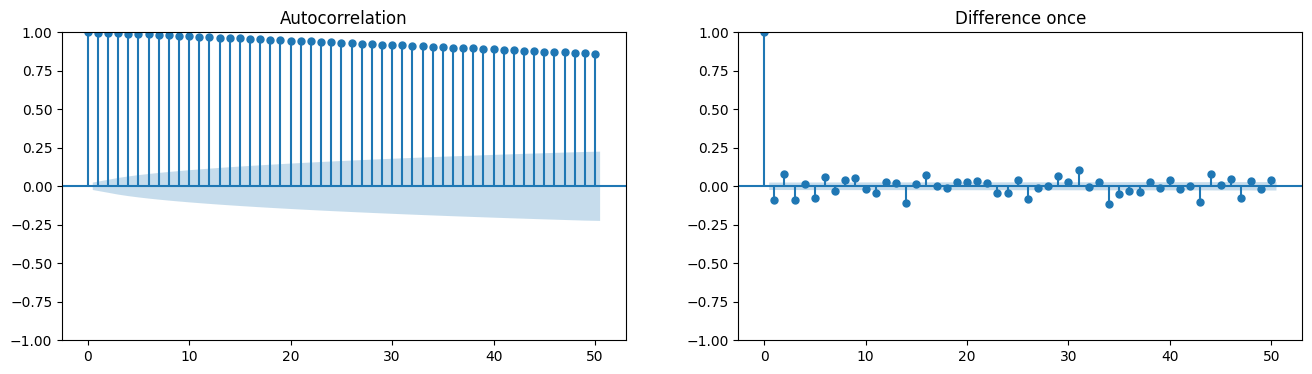

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

price = NVDA_data["Close"]
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))
price_diff = price.diff().dropna()


plot_acf(price, lags=50, ax=ax1)  # Check autocorrelation
plot_acf(price_diff, lags=50, ax=ax2)
ax2.set_title("Difference once")

In [6]:
# To check if the number of samples is enough
for days in [5, 7, 10, 14, 20]:
    print(f"Sampling every {days} days: {len(price.values[::days])} samples remaining")

Sampling every 5 days: 1310 samples remaining
Sampling every 7 days: 936 samples remaining
Sampling every 10 days: 655 samples remaining
Sampling every 14 days: 468 samples remaining
Sampling every 20 days: 328 samples remaining


In [7]:
# 2. Prepare input data (resample and ensure 1D)
forecast_input = [
    np.array(price.values[::5]).flatten(),   # Every 5th day
    np.array(price.values[::7]).flatten(),  # Every 7th day
    np.array(price.values[::10]).flatten(),  # Every 10th day
]

# 3. Ensure all arrays have the same length
min_length = min(len(arr) for arr in forecast_input)
forecast_input = [arr[:min_length] for arr in forecast_input]

### Determining of the frequency input
In particular regarding the frequency, TimesFM expects a categorical indicator valued in {0, 1, 2}:

- 0 (default): high frequency, long horizon time series. We recommend using this for time series up to daily granularity.
- 1: medium frequency time series. We recommend using this for weekly and monthly data.
- 2: low frequency, short horizon time series. We recommend using this for anything beyond monthly, e.g. quarterly or yearly.
This categorical value should be directly provided with the array inputs. For dataframe inputs, we convert the conventional letter coding of frequencies to our expected categories, that

0: T, MIN, H, D, B, U

1: W, M

2: Q, Y

In [8]:
# 4. Frequency input 
frequency_input = [0]

In [9]:
#5. Build input dataframe for TimesFM
# Create the dataframe in the format required by TimesFM
input_df = pd.DataFrame({
    "unique_id": ["NVDA"] * len(NVDA_data),  # Use "NVDA" as the unique identifier
    "ds": NVDA_data["Date"],                # Date column
    "y": NVDA_data["Close"]                 # Closing price
})

# 3. Ensure y values are 1-dimensional
# Flatten y to ensure it is a 1D array
input_df["y"] = input_df["y"].values.flatten()


# 6. Forecast using TimesFM
# Pass the input dataframe to the TimesFM model for forecasting
forecast_df = tfm.forecast_on_df(
    inputs=input_df,  # Input dataframe
    freq="D",         # Daily frequency
    value_name="y",   # The column to predict
    num_jobs=-1       # Use all available cores for parallel processing
)

# 7. Display forecast results
print(forecast_df)


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].
Finished preprocessing dataframe.
Finished forecasting.
   unique_id                        ds     timesfm  timesfm-q-0.1  \
0       NVDA 2025-02-04 00:00:00-05:00  119.249527     111.743637   
1       NVDA 2025-02-05 00:00:00-05:00  118.394989     109.109192   
2       NVDA 2025-02-06 00:00:00-05:00  118.093658     107.389053   
3       NVDA 2025-02-07 00:00:00-05:00  117.423599     106.305588   
4       NVDA 2025-02-08 00:00:00-05:00  117.634186     105.265717   
5       NVDA 2025-02-09 00:00:00-05:00  118.178589     105.193024   
6       NVDA 2025-02-10 00:00:00-05:00  117.058395     103.439468   
7       NVDA 2025-02-11 00:00:00-05:00  116.192078     101.320206   
8       NVDA 2025-02-12 00:00:00-05:00  116.095306     100

# TimesFM Forecast Interpretation
The forecast results include multiple columns that represent the predicted values and their uncertainty ranges. Here's how to interpret the key columns:


- timesfm: Median prediction (most likely value).

- timesfm-q-0.1: 10% quantile prediction (lower range of uncertainty).

- timesfm-q-0.5: 50% quantile prediction (equivalent to timesfm median).

- timesfm-q-0.9: 90% quantile prediction (higher range of uncertainty, if available).


<Example Interpretation: > 
For a given date (e.g., 2025-01-28):

- Median prediction (timesfm): 393.19 → The most likely stock price.

- 10% quantile (timesfm-q-0.1): 371.13 → Lower bound of the range.

- 50% quantile (timesfm-q-0.5): 393.19 → The central prediction (same as timesfm).

- 90% quantile: (if present) Higher bound of the range.

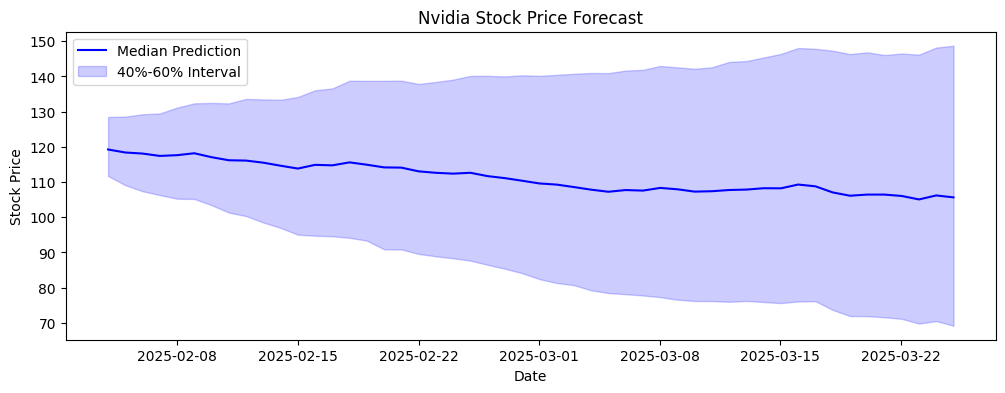

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(forecast_df["ds"], forecast_df["timesfm"], label="Median Prediction", color="blue")
plt.fill_between(
    forecast_df["ds"],
    forecast_df["timesfm-q-0.1"],
    forecast_df["timesfm-q-0.9"],
    color="blue",
    alpha=0.2,
    label="40%-60% Interval"
)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Nvidia Stock Price Forecast")
plt.legend()
plt.show()


# Predicting Tomorrow's NVDA stock price

In [11]:
from datetime import datetime, timedelta

# Generate the next day's datetime
today = datetime.today()
tmr = (today + timedelta(days=1)).date()  

# Ensure both tmr and forecast_df["ds"] are datetime
forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])  # Convert to datetime
filtered_df = forecast_df[forecast_df["ds"].dt.date == tmr]  # Compare dates directly

print(filtered_df)

  unique_id                        ds     timesfm  timesfm-q-0.1  \
1      NVDA 2025-02-05 00:00:00-05:00  118.394989     109.109192   

   timesfm-q-0.2  timesfm-q-0.3  timesfm-q-0.4  timesfm-q-0.5  timesfm-q-0.6  \
1     112.742096     115.058334     116.938843     118.394989     120.275635   

   timesfm-q-0.7  timesfm-q-0.8  timesfm-q-0.9  
1     122.182007     124.825653     128.600159  


In [12]:
print(tmr)

2025-02-05


### 1. Split the data 2010-2024 - to train, 2025 to predict 

In [13]:
# NVDA_data.head()

GetNVDA = yf.Ticker("NVDA")
NVDA_data=GetNVDA.history(period="max")

train=NVDA_data.loc['2010-06-29':'2024-12-31']
test=NVDA_data.loc['2025-01-01':'2025-12-31']

train.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,0.248989,0.249218,0.238671,0.240276,660808000,0.0,0.0
2010-06-30 00:00:00-04:00,0.240735,0.243257,0.234086,0.234086,623072000,0.0,0.0
2010-07-01 00:00:00-04:00,0.234774,0.239589,0.227666,0.237984,737008000,0.0,0.0
2010-07-02 00:00:00-04:00,0.238901,0.239359,0.226979,0.235003,737096000,0.0,0.0
2010-07-06 00:00:00-04:00,0.234086,0.241652,0.230418,0.232481,712020000,0.0,0.0


In [14]:
# the number of test, train
print(len(train), len(test))

3652 21


In [15]:
train.reset_index(inplace=True) 

#5. Build input dataframe for TimesFM
# Create the dataframe in the format required by TimesFM
input_df = pd.DataFrame({
    "unique_id": ["NVDA"] * len(train),  # Use "NVDA" as the unique identifier
    "ds": train["Date"],                # Date column
    "y": train["Close"]                 # Closing price
})


# 3. Ensure y values are 1-dimensional
# Flatten y to ensure it is a 1D array
input_df["y"] = input_df["y"].values.flatten()


# 6. Forecast using TimesFM
# Pass the input dataframe to the TimesFM model for forecasting
forecast_df = tfm.forecast_on_df(
    inputs=input_df,  # Input dataframe
    freq="D",         # Daily frequency
    value_name="y",   # The column to predict
    num_jobs=-1       # Use all available cores for parallel processing
)

# 7. Display forecast results
print(forecast_df)


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].
Finished preprocessing dataframe.
Finished forecasting.
   unique_id                        ds     timesfm  timesfm-q-0.1  \
0       NVDA 2025-01-01 00:00:00-05:00  137.756973     132.145859   
1       NVDA 2025-01-02 00:00:00-05:00  137.288910     130.983017   
2       NVDA 2025-01-03 00:00:00-05:00  136.795456     129.334259   
3       NVDA 2025-01-04 00:00:00-05:00  136.864578     128.629837   
4       NVDA 2025-01-05 00:00:00-05:00  137.929047     128.422775   
5       NVDA 2025-01-06 00:00:00-05:00  138.109024     127.926231   
6       NVDA 2025-01-07 00:00:00-05:00  138.281158     127.649292   
7       NVDA 2025-01-08 00:00:00-05:00  138.029556     126.818810   
8       NVDA 2025-01-09 00:00:00-05:00  138.608765     126

In [16]:
input_df

,unique_id,ds,y
0,NVDA,2010-06-29 00:00:00-04:00,0.240276
1,NVDA,2010-06-30 00:00:00-04:00,0.234086
2,NVDA,2010-07-01 00:00:00-04:00,0.237984
3,NVDA,2010-07-02 00:00:00-04:00,0.235003
4,NVDA,2010-07-06 00:00:00-04:00,0.232481
...,...,...,...
3647,NVDA,2024-12-24 00:00:00-05:00,140.220001
3648,NVDA,2024-12-26 00:00:00-05:00,139.929993
3649,NVDA,2024-12-27 00:00:00-05:00,137.009995
3650,NVDA,2024-12-30 00:00:00-05:00,137.490005


### 2. Compare actual vs predict


In [17]:
# forecast_df["ds"]

In [18]:
# forecast_df["timesfm"]

In [19]:
# train.head()

In [20]:
# train.index = train['Date']
# train.head()

# #remove index column from train
# train.drop(columns=['index'], inplace=True)
# train.head()

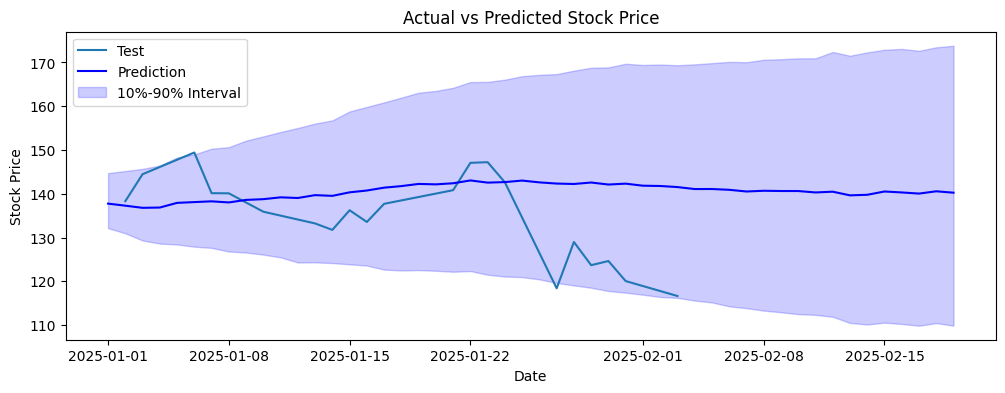

In [21]:
# Plot actual and predicted values for the test set

plt.figure(figsize=(12,4))
# plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(forecast_df["ds"], forecast_df["timesfm"], label="Prediction", color="blue")
plt.fill_between(
    forecast_df["ds"],
    forecast_df["timesfm-q-0.1"],
    forecast_df["timesfm-q-0.9"],
    color="blue",
    alpha=0.2,
    label="10%-90% Interval"
)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Price")
plt.legend()
plt.show()



### 3. performance valuation matrix ( mse, rsme, mae, r-square)

-  set the seed 
- try different seed value and check if the result is the same or not.
- improve hyperparameter (try)
- when I make the markdown note, I should know what each parameter do (taking note for everything)s

In [22]:
# forecast_df["timesfm"]

In [23]:
# test['Close']

In [24]:

# performance valuation matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Align forecast_df with test set
aligned_forecast_df = forecast_df[forecast_df["ds"].isin(test.index)]

# Calculate MSE
mse = mean_squared_error(test['Close'], aligned_forecast_df["timesfm"])

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(test['Close'], aligned_forecast_df["timesfm"])

# Calculate R2
r2 = r2_score(test['Close'], aligned_forecast_df["timesfm"])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")


RMSE: 11.85553491867495
MAE: 8.90373302641369
R2: -0.5715075304127415
